## Aluno: Gustavo Gimpel Correia Lima
## Matrícula: `201512040488`

Esta prática foi baseada no Capítulo 4 do livro "Deep Learning with Python" (Chollet F., 2017). Nela iremos estudar arquiteturas de Redes Neurais Profundas para identificar gatos e cachorros em fotos. Esse dataset foi uma amostra extraida do [desafio do Kaggle](colab.research.google.com). O objetivo desta prática é:
- demonstrar como é possível usar Redes Neurais Convolucionarias (CNN)  mesmo em um dataset pequeno;
- conhecer o framework Keras;
- apresentar, por meio de mini-batches, como usar de forma eficiente a memória quando possuimos um dataset com milhares de atributos e, consequentemente, consumiria muita memória principal;
- demonstrar a vantagem da CNN ao comparar  com uma Rede Neural Totalmente Conectada (FC, do inglês _Fully Connected Network_) quando a entrada é uma imagem.





A limitação dessa prática é que assumimos que a imagem corresponde a apenas um animal (ou vários sendo apenas cachorros ou apenas gatos). Em um problema maior, deveriamos identificar objetos na imagem, para, logo após, realizarmos cortes na imagem e classificamos cada objeto identificado. 

Esta prática não possui testes unitários mas, para cada atividade, apresento que é esperado da mesma (ou como testar seu funcionamento). 

## Configuração da prática

Primeiramente, você deverá instalar o Keras e o TensorFlow:

pip3 install keras, tensorflow, pydot

In [93]:
!pip3 install keras tensorflow-cpu pydot -q
from IPython.display import Image
from cats_vs_dogs import *
from keras.preprocessing.image import ImageDataGenerator,array_to_img
from keras import Model
from keras import layers
from keras import Input
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import datetime
import math

%load_ext tensorboard
%rm -rf "./logs/fit/"

def getLogdir(modelName):
    dir = "./logs/fit/" + str(modelName)
    return dir



You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Veja a inicialização da classe `Constantes` e da `ParametrosRedeNeural` no arquivo `cats_vs_dogs.py`. Você precisará desses valores ao longo da prática. Veja que lá, passamos o tipo de otimização usando classes do módulo [optimizers](https://keras.io/optimizers/) do Keras. Dentro desse objeto que definimos a taxa de aprendizado. No otimizador RMSProp, o parametro $\beta$ que usamos na nossa aula teórica é o parâmetro `rho` da inicialização da classe `RMSProp`.

## Notação utilizada

- $m$: quantidade de instâncias;
- $t$: tamanho do mini-batch;
- $w$: largura da imagem. Toda imagem possuirá o mesmo tamanho;
- $h$: altura da imagem;
- $c$: número de canais da imagem (ex. 1 canal: escala de cinzas; 3 canais: vermelho, verde e azul);
- $X$: Matriz de instâncias representadas pelos pixels das imagens. A ordem da matriz é $t \times h \times w \times c$;
- $\pmb{y}$: Vetor de tamanho $m$ representando a classe real de cada instância;
- $\pmb{\hat{y}}$: Vetor de predições que, para cada instancia, possui o valor predito para ela. Caso seja uma classificação binária, este valor será 0 ou 1.

## Obtenção do Dataset utilizando Batches e DataGenerator

Iremos usar um dataset de 4096 fotos de cachorros e gatos em que são 2048 fotos de cachorros e 2048 fotos de gato. Ele foi dividido de forma balanceada e aleatória em treino (2048 instancias), validação (1024 instâncias) e teste (1024 instâncias). Esse dataset está [disponivel no GitHub](https://github.com/daniel-hasan/cats-vs-dogs/archive/master.zip). Efetue o download, armazene no diretório `data` para fazer as tarefas. 

Ao trabalharmos milhares/milhões de imagens, nos deparamos com um problema: não conseguimos armazenar todas elas em memória principal. Por isso, a utilização do mini-batch gradient decent é importante, junto com os algoritmos de otimização que aprendemos (Gradiente Descent with Momentum, RMSProp e Adam). 

O Keras possui a classe [ImageGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) para preprocessar imagens,  trabalhar com mini-batches de imagens e fazer, inclusive, _Data Augmentation_.  Na primeira parte desta prática iremos utilizá-la apenas para facilitar o uso de mini-batches e realizar o preprocessamento. Mais especificamente, iremos usar o método [flow_from_data_dir](https://keras.io/preprocessing/image/#flow_from_directory) que recebe como entrada uma estrutura de diretórios similar a esta:

<img src="imgs/dataset-generator.png">

Nessa estrutura, cada subdiretório será uma classe com todas as imagens referentes a ela. `flow_from_data_dir` retorna um objeto iterável que, em cada iteração, retornará a tupla $(X,\pmb{y})$, ou seja, um mini-batch $X$ e o vetor de classe $\pmb{y}$ de cada instancia retornada pelo mini-batch (ver notação utilizada). Dessa forma, esse método armazena em memória principal apenas $t$ imagens por vez, ao invés do dataset completo.  

O `flow_from_data_dir` retorna um iterador que entraria em um loop infinito: após iterar sobre todas as imagens, ele faz a operação toda novamente. Por isso, caso desejarmos navegar em todas as imagens por um `for`, temos que definir um ponto de parada que, sem _data augmentation_, é o número de imagens. 

**Atividade 1 - Hello World DataGenerator:** crie uma pasta `img_toy_test` baseando-se estrutura acima com duas classes. Na primeira, coloque três cachorrinhos e, na outra, três gatinhos de sua escolha. Complete o código da função `plot_imgs_from_iterator` para efetuar a exibição dos mesmos. Essa função não possui teste unitário.  

Found 6 images belonging to 2 classes.
x treino shape: (2, 150, 150, 3)
y treino shape: (2,)


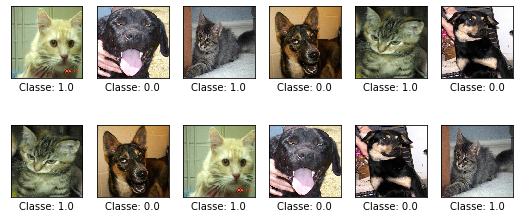

In [2]:
#No image generator, você usará apenas um parametro rescale 
#..para deixar cada pixel entre 0 e 1. 
#..Lembre-se que cada pixel originalmente é um valor entre 0 e 255
img_generator = ImageDataGenerator(rescale=1/255)

#ao fazer o iterador, você deverá definir: 
#..O tamanho para que todas as imagens sejam redimensionadas; 
#..O modo de classificação que será binário (caso contrario, a representação nao seria um vetor)
#..O seed sempre fixo de Constantes.SEED para permitirmos a reprodutibilidade dos experimentos
#..Escolha um tamanho do batch de 2
it_datagen = img_generator.flow_from_directory(
                                                       "img_toy_test",
                                                        target_size=(150, 150),
                                                        batch_size=2,
                                                        class_mode="binary",
                                                        seed=2
                                                        )
plot_imgs_from_iterator(it_datagen,2,6)

Veja que o iterador passou duas vezes pelas imagens apresentando, aleatoriamente, cada uma das imagens. Verifique as dimensões (shape) dos elementos para entender como as imagens foram representadas. Apenas na apresentação, o tamanho da imagem apresentada pelo gnuplot é redimensionada proporcional ao valor passado na função figsize. 

**Atividade 2 - função `get_dataset`:** Nosso dataset já foi dividido em 3 partições: treino, teste e validação. Entendendo o funcionamento do `ImageDataGenerator`, você deverá implementar a função `get_dataset` que retornará um vetor três iteradores um para o treino, outro para teste e outro para validação. Esse vetor de iteradores obedecerá a mesma ordem de `Constantes.ARR_STR_DATA_DIR`. Para testar, você pode fazer um treino, teste e validação cada um com 6 itens e testar usando o `plot_imgs_from_iterator`.

In [3]:
get_dataset(ParametrosRedeNeural(int_num_epochs=1), Constantes.ARR_STR_DATA_DIR)

Dataset: data/treino
Found 2048 images belonging to 2 classes.
Dataset: data/validacao
Found 1024 images belonging to 2 classes.
Dataset: data/teste
Found 1024 images belonging to 2 classes.


## Criação dos modelos para identificar gatineos e cachorrineos

Como a execução dos modelos que iremos criar pode demorar uns 30 minutos, iremos, primeiramente criar cada modelo para, na próxima seção, executarmos e fazermos a análise. Sempre consideramos que a imagem possuirá as dimensões 150x150x3.

**Atividade 3 - Criação de uma Fully Connected Network (FC) usando Keras:** Inicialmente, iremos implementar uma Rede Neural Totalmente Conectada (sem uso de convoluções) por meio do Keras. Você deverá implementar a seguinte Rede Neural:

<img src="imgs/arquitetura-fc.png">

Existem duas formas de implementar uma Rede Neural no Keras. Abaixo apresentamos o uso da [API funcional do Keras](https://keras.io/getting-started/functional-api-guide/) para uma arquetura similar aquela que você irá implementar. Existe outra API ([Sequential Model](https://keras.io/getting-started/sequential-model-guide/)), porém ela é menos flexivel. Perceba que aqui você irá criar o modelo/arquitetura mas ainda não irá realizar o treinamento.

In [4]:
#entrada (imagens de dimensões 150x150x3)
entrada = Input(shape=(150,150,3),name="Entrada")

achatar = layers.Flatten()(entrada)
#uma camada (ativação = relu) com 100 neuronios (unidades) a entrada (em formato de vetor) é passada como parametro
camada_um = layers.Dense(100,activation="relu",name="Camada1")(achatar)
camada_dois = layers.Dense(200,activation="relu",name="Camada2")(camada_um)
#camada de saida
#lembre-se que é uma classificação binária, a ativação é sigmoid
saida = layers.Dense(1,activation="sigmoid", name="saida")(camada_dois)

#cria-se o modelo
modelo = Model(inputs=entrada, outputs=saida)

Cada variável `camada_*` é uma camada. Veja que passamos uma camada como entrada da outra. [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) é uma FC, ou seja, umacamada totalmente conectada (pois, podemos chamá-la também de densely conected layers). Usamos uma camada [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) para "achatar"  a representação. Ou seja, cada instancia de imagem é representada por uma matriz 150x150x3 é transformada em um vetor de 67.500 atributos. Podemos ver a arquitetura usando `modelo.summary()`. Também podemos usar a função [plot_model](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model) para exibir a imagem da arquitetura também - para visualizar a imagem, é necessário instalar algumas dependencias. 

In [5]:
modelo.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Entrada (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 67500)             0         
_________________________________________________________________
Camada1 (Dense)              (None, 100)               6750100   
_________________________________________________________________
Camada2 (Dense)              (None, 200)               20200     
_________________________________________________________________
saida (Dense)                (None, 1)                 201       
Total params: 6,770,501
Trainable params: 6,770,501
Non-trainable params: 0
_________________________________________________________________


Veja que, mesmo uma rede neural com pouca profundidade, temos milhões de parametros a serem aprendidos.

Agora, implemente a função `fully_connected_model` do arquivo `cats_vs_dogs.py` a seguinte rede neural totalmente conectada:

Execute a função abaixo e armazene o modelo em `model_fc`. O número esperado de parametros a serem aprendidos é de 33.870.901.

In [6]:
model_fc = fully_connected_model()
model_fc.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Entrada (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 67500)             0         
_________________________________________________________________
Camada1 (Dense)              (None, 500)               33750500  
_________________________________________________________________
Camada2 (Dense)              (None, 200)               100200    
_________________________________________________________________
Camada3 (Dense)              (None, 100)               20100     
_________________________________________________________________
saida (Dense)                (None, 1)                 101       
Total params: 33,870,901
Trainable params: 33,870,901
Non-trainable params: 0
_______________________________________________

**Atividade 4 - criação de uma Rede Neural Convolucional:** Agora você implementará na função `simple_cnn_model` o modelo da seguinte rede convolucional usando o Keras: 

<img src="imgs/arquitetura-cnn.png">

Para isso, veja a seguir um exemplo das camadas de convolução e MaxPooling ([Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) e [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)):

In [7]:
entrada = Input(shape=(150,150,3),name="Entrada")
conv_2d_a = layers.Conv2D(32,(3,3),activation="relu",name="Convolucao1")(entrada)
max_polling_a = layers.MaxPool2D((2,2))(conv_2d_a)

Esse exemplo é a parte inicial da arquitetura que você deverá implementar. Não esqueça de 
usar Flatten quando necessário. Logo após "achatar" a representação em um vetor, caso o parametro `add_dropout==True` você deverá usar o [Dropout](https://keras.io/layers/core/) em que 50% das ativações serão aleatoriamente zeradas. Abaixo, crie o modelo e armazene em `model_cnn_dropout` e  `model_cnn` as versões com e sem dropout, respectivamente. As duas arquiteturas possuirão 3.453.121 parametros a serem aprendidos. 

In [8]:
model_cnn = simple_cnn_model(add_dropout=False)
model_cnn_dropout = simple_cnn_model(add_dropout=True)

Exiba as arquiteturas das CNNs criadas

In [9]:
model_cnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Entrada (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
Convolucao1 (Conv2D)         (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
Convolucao2 (Conv2D)         (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
Convolucao3 (Conv2D)         (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0   

In [10]:
model_cnn_dropout.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Entrada (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
Convolucao1 (Conv2D)         (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
Convolucao2 (Conv2D)         (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
Convolucao3 (Conv2D)         (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0   

## Uso de Data Augmentation 

**Atividade 5 - Data Augmentation** Antes de rodar os modelos, iremos também aprender a utilizar _data augmentation_ em imagens. Para isso, no ImageGenerator abaixo, você usará, além do parametro rescale, parametros que serão reponsáveis por:
- Executar rotações aleatorias na imagem (com limite de 40 graus)
- aumentar/diminuir a largura e altura em 20%
- Zoom in/out de 20% 
- cisalhamento (inclinação) de 20%
- Espelhamento horizontal

In [11]:
# 
#..para deixar cada pixel entre 0 e 1. 
#..Lembre-se que cada pixel originalmente é um valor entre 0 e 255
img_generator_aug = ImageDataGenerator(rescale=1/255,
                                 #[rotation_range]: Int. Degree range for random rotations.
                                 rotation_range=40,  
                                 #[width_shift_range]: float: fraction of total width, if < 1
                                 width_shift_range=0.2,
                                 #[height_shift_range]: float: fraction of total height, if < 1
                                 height_shift_range=0.2,
                                 #[shear_range]: Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
                                 shear_range=20.0,
                                 #[zoom_range]: Float or [lower, upper]
                                 zoom_range=[0.8, 1.2],
                                 #[horizontal_flip]: Boolean. Randomly flip inputs horizontally.
                                 horizontal_flip=True) 



Faça o _Data Augmentation_ no dataset nosso de teste `img_toy_test` e execute o plot_imgs_from_iterator. Você peceberá que o DataGenerator nunca gera exatamente a mesma imagem. 

Found 6 images belonging to 2 classes.
x treino shape: (2, 150, 150, 3)
y treino shape: (2,)


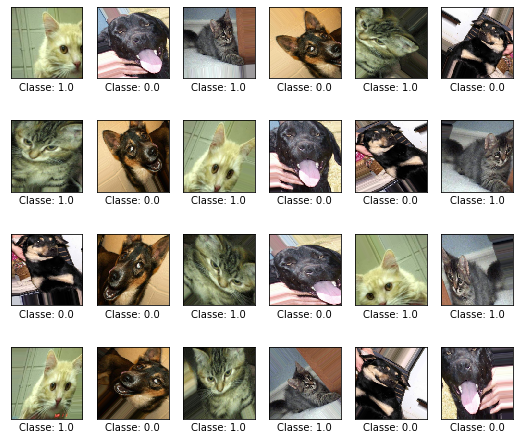

In [12]:
it_datagen = img_generator_aug.flow_from_directory(
                                                       "img_toy_test",
                                                        target_size=(150,150),
                                                        batch_size=2,
                                                        class_mode='binary',
                                                        seed=Constantes.SEED
                                                        )
plot_imgs_from_iterator(it_datagen,4,6)

## Execução e avaliação dos métodos usados

**Atividade 6 - Criação da função run_model:** Crie a função `run_model` nela, você deverá:

1. compile o modelo por meio do [método compile](https://keras.io/models/model/#compile) do objeto;
2. também no objeto do modelo, execute o método [fit_generator](https://keras.io/models/model/#fit_generator) para criar o modelo. Esse método é o que recebe como parametro o iterador que aprendemos nas seções anteriores. Não será usado neste prática, mas também existe o [método fit](https://keras.io/models/model/#fit) que recebe como parametro os atributos - neste caso seria a matriz $X$ (similar ao scikit learn).
3. Salve o modelo: A criação do modelo é uma parte custosa - em nossa prática pode durar de 15 a 30 minutos. Porém, alguns modelos poderiam demorar dias/semanas para serem criados, dependendo da profundidade e número de pesos a serem aprendidos. Por isso, é uma boa prática salvar os modelos por meio do método [save](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model). Se necessário, você pode carregar o modelo por meio da função [load_model](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model). Você pode também [salvar checkpoints do modelo](https://www.tensorflow.org/tutorials/keras/save_and_load) (opcional na prática);
4. Avalie o modelo usando validação usando o [método evaluate_generator](https://keras.io/models/sequential/#evaluate_generator) e retorne a acurácia

**Atividade 7 - Execução dos modelos**: Execute os modelos criados `model_fc`, `model_cnn` e `model_cnn_dropout` com a função run_model. Obtenha o resultado da validação. Sem GPU, a execução de cada modelo levar de 30 minutos a 4 horas. Você pode mandar executar e ir dormir :) - ou, para testar, diminua para um o número de épocas para ver funcionando mais rápido e, logo após, execute "de verdade" com os parametros padrão. Você pode também usar a GPU do [Google colab](colab.research.google.com) (coloque o link do seu colab aqui para ser avaliado). Com o colab, você terá apenas um trabalho a mais para enviar o dataset ao colab.

In [13]:
#parametros - deixar o padrao
param_default = ParametrosRedeNeural(int_num_epochs=10)

In [14]:
#sempre pegar o dataset - para reiniciar o iterator
arr_it_gen = get_dataset(param_default,Constantes.ARR_STR_DATA_DIR)
#rode run_model para o fully connected model use o arr_it_gen em cada posição
#.. Constantes.IDX_TREINO e Constantes.IDX_VALIDACAO para pegar os iteradores
log_dir = getLogdir('fc')
filename = param_default.toString() + "fc.h5"
callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_fc, loss_fc, acc_fc = run_model(model=model_fc,
                           it_gen_train=arr_it_gen[Constantes.IDX_TREINO],
                           it_gen_validation=arr_it_gen[Constantes.IDX_VALIDACAO],
                           param_training=param_default,
                           str_file_to_save=filename,
                           #a quantidade de passos na validação deve ser a apresentada abaixo
                           #pois precisamos de garanteir que o iterador da validação passe 
                           #por todos os itens de validação
                           int_val_steps=Constantes.QTD_VALIDACAO/param_default.int_batch_size,
                           callback=callback)
print(f"Acurácia FC: {acc_fc}")

Dataset: data/treino
Found 2048 images belonging to 2 classes.
Dataset: data/validacao
Found 1024 images belonging to 2 classes.
Dataset: data/teste
Found 1024 images belonging to 2 classes.


/home/gustavogimpel/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
32/32 [==============================] - 9s 264ms/step - loss: 38.7923 - accuracy: 0.4808 - val_loss: 28.3247 - val_accuracy: 0.5000
Epoch 2/10
32/32 [==============================] - 8s 252ms/step - loss: 7.6106 - accuracy: 0.5119 - val_loss: 3.1596 - val_accuracy: 0.5000
Epoch 3/10
32/32 [==============================] - 8s 248ms/step - loss: 2.9671 - accuracy: 0.4898 - val_loss: 3.8059 - val_accuracy: 0.5000
Epoch 4/10
32/32 [==============================] - 8s 247ms/step - loss: 1.8833 - accuracy: 0.4873 - val_loss: 0.7443 - val_accuracy: 0.5146
Epoch 5/10
32/32 [==============================] - 8s 243ms/step - loss: 1.4137 - accuracy: 0.5376 - val_loss: 0.7078 - val_accuracy: 0.5000
Epoch 6/10
32/32 [==============================] - 8s 247ms/step - loss: 0.7519 - accuracy: 0.4975 - val_loss: 0.6868 - val_accuracy: 0.5498
Epoch 7/10
32/32 [==============================] - 8s 252ms/step - loss: 0.7881 - accuracy: 0.5402 - val_loss: 0.6941 - val_accuracy: 0.5527
Epoc

/home/gustavogimpel/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Acurácia FC: 0.5


In [15]:
%tensorboard --logdir "./logs/fit/fc" --host localhost

Reusing TensorBoard on port 6007 (pid 35376), started 2:46:34 ago. (Use '!kill 35376' to kill it.)

In [16]:
param_default = ParametrosRedeNeural(int_num_epochs=10)

In [17]:
#sempre pegar o dataset - para reiniciar o iterator
arr_it_gen = get_dataset(param_default,Constantes.ARR_STR_DATA_DIR)
#rode para run_model a CNN (sem dropout)
log_dir = getLogdir('cnn')
filename = param_default.toString() + "cnn.h5"
callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_cnn, loss_cnn, acc_cnn = run_model(model=model_cnn,
                           it_gen_train=arr_it_gen[Constantes.IDX_TREINO],
                           it_gen_validation=arr_it_gen[Constantes.IDX_VALIDACAO],
                           param_training=param_default,
                           str_file_to_save=filename,
                           #a quantidade de passos na validação deve ser a apresentada abaixo
                           #pois precisamos de garanteir que o iterador da validação passe 
                           #por todos os itens de validação
                           int_val_steps=Constantes.QTD_VALIDACAO/param_default.int_batch_size,
                           callback=callback)
print(f"Acurácia CNN: {acc_cnn}")

Dataset: data/treino
Found 2048 images belonging to 2 classes.
Dataset: data/validacao
Found 1024 images belonging to 2 classes.
Dataset: data/teste
Found 1024 images belonging to 2 classes.
Epoch 1/10
32/32 [==============================] - 26s 781ms/step - loss: 1.3418 - accuracy: 0.5295 - val_loss: 0.6922 - val_accuracy: 0.5020
Epoch 2/10
32/32 [==============================] - 24s 762ms/step - loss: 0.6934 - accuracy: 0.5026 - val_loss: 0.6916 - val_accuracy: 0.5107
Epoch 3/10
32/32 [==============================] - 24s 753ms/step - loss: 0.6933 - accuracy: 0.5268 - val_loss: 0.6877 - val_accuracy: 0.5137
Epoch 4/10
32/32 [==============================] - 25s 791ms/step - loss: 0.6973 - accuracy: 0.5760 - val_loss: 0.6828 - val_accuracy: 0.5723
Epoch 5/10
32/32 [==============================] - 25s 774ms/step - loss: 0.6631 - accuracy: 0.6146 - val_loss: 0.6304 - val_accuracy: 0.6553
Epoch 6/10
32/32 [==============================] - 25s 782ms/step - loss: 0.6378 - accuracy: 

In [18]:
%tensorboard --logdir "./logs/fit/cnn" --host localhost

Reusing TensorBoard on port 6007 (pid 36297), started 2:46:59 ago. (Use '!kill 36297' to kill it.)

In [19]:
param_default = ParametrosRedeNeural(int_num_epochs=10)

In [20]:
#sempre pegar o dataset - para reiniciar o iterator
arr_it_gen = get_dataset(param_default,Constantes.ARR_STR_DATA_DIR)
#rode run_model para a CNN (com dropout)
log_dir = getLogdir('dropout')
filename = param_default.toString() + "dropout.h5"
callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_cnn_dropout, loss_cnn_dropout, acc_cnn_dropout = run_model(model=model_cnn_dropout,
                           it_gen_train=arr_it_gen[Constantes.IDX_TREINO],
                           it_gen_validation=arr_it_gen[Constantes.IDX_VALIDACAO],
                           param_training=param_default,
                           str_file_to_save=filename,
                           #a quantidade de passos na validação deve ser a apresentada abaixo
                           #pois precisamos de garanteir que o iterador da validação passe 
                           #por todos os itens de validação
                           int_val_steps=Constantes.QTD_VALIDACAO/param_default.int_batch_size,
                           callback=callback)
print(f"Acurácia CNN (Dropout): {acc_cnn_dropout}")

Dataset: data/treino
Found 2048 images belonging to 2 classes.
Dataset: data/validacao
Found 1024 images belonging to 2 classes.
Dataset: data/teste
Found 1024 images belonging to 2 classes.
Epoch 1/10
32/32 [==============================] - 26s 785ms/step - loss: 0.8551 - accuracy: 0.5095 - val_loss: 0.6907 - val_accuracy: 0.6211
Epoch 2/10
32/32 [==============================] - 25s 768ms/step - loss: 0.7048 - accuracy: 0.5529 - val_loss: 0.6919 - val_accuracy: 0.6152
Epoch 3/10
32/32 [==============================] - 25s 778ms/step - loss: 0.6916 - accuracy: 0.5424 - val_loss: 0.6839 - val_accuracy: 0.6172
Epoch 4/10
32/32 [==============================] - 25s 776ms/step - loss: 0.6930 - accuracy: 0.5530 - val_loss: 0.6786 - val_accuracy: 0.5596
Epoch 5/10
32/32 [==============================] - 25s 771ms/step - loss: 0.6817 - accuracy: 0.5804 - val_loss: 0.6517 - val_accuracy: 0.6377
Epoch 6/10
32/32 [==============================] - 25s 779ms/step - loss: 0.6509 - accuracy: 

In [21]:
%tensorboard --logdir "./logs/fit/dropout" --host localhost

Reusing TensorBoard on port 6008 (pid 45431), started 2:15:13 ago. (Use '!kill 45431' to kill it.)

**Atividade 8 - Data Augmentation** Agora, execute o modelo `model_cnn_dropout` porém usando `data augmentation`. Para isso, use o `img_generator_aug` (criado na seção anterior) e crie o iterador que percorra o dataset treino. Use o batch size de `param_default.int_batch_size` que é o mesmo usado no treino e use `Constantes.ARR_STR_DATA_DIR[Constantes.IDX_TRAIN]` para obter o diretório do treino. 

In [22]:
param_default = ParametrosRedeNeural(int_num_epochs=30)

it_gen_aug_train = img_generator_aug.flow_from_directory(
                                                        Constantes.ARR_STR_DATA_DIR[Constantes.IDX_TREINO],
                                                        target_size=(150,150),
                                                        batch_size=2,
                                                        class_mode='binary',
                                                        seed=Constantes.SEED
                                                        )

it_gen_aug_test = img_generator_aug.flow_from_directory(
                                                        Constantes.ARR_STR_DATA_DIR[Constantes.IDX_TESTE],
                                                        target_size=(150,150),
                                                        batch_size=2,
                                                        class_mode='binary',
                                                        seed=Constantes.SEED
                                                        )

Found 2048 images belonging to 2 classes.
Found 1024 images belonging to 2 classes.


In [23]:
arr_it_gen = get_dataset(param_default,Constantes.ARR_STR_DATA_DIR)

log_dir = getLogdir('dropout_aug')
filename = param_default.toString() + "dropout_aug.h5"
callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_cnn_dropout_aug, loss_cnn_data_aug, acc_cnn_data_aug = run_model(model=model_cnn_dropout,
                           it_gen_train=it_gen_aug_train[Constantes.IDX_TREINO],
                           it_gen_validation=it_gen_aug_train[Constantes.IDX_VALIDACAO],
                           param_training=param_default,
                           str_file_to_save=filename,
                           #a quantidade de passos na validação deve ser a apresentada abaixo
                           #pois precisamos de garanteir que o iterador da validação passe 
                           #por todos os itens de validação
                           int_val_steps=Constantes.QTD_VALIDACAO/param_default.int_batch_size,
                           callback=callback)
print(f"Acurácia CNN (data augmentation): {acc_cnn_data_aug}")

Dataset: data/treino
Found 2048 images belonging to 2 classes.
Dataset: data/validacao
Found 1024 images belonging to 2 classes.
Dataset: data/teste
Found 1024 images belonging to 2 classes.
Epoch 1/10
32/32 [==============================] - 25s 753ms/step - loss: 0.5863 - accuracy: 0.7087 - val_loss: 0.6643 - val_accuracy: 0.6592
Epoch 2/10
32/32 [==============================] - 24s 745ms/step - loss: 0.4688 - accuracy: 0.7743 - val_loss: 0.5872 - val_accuracy: 0.7012
Epoch 3/10
32/32 [==============================] - 24s 745ms/step - loss: 0.4292 - accuracy: 0.8012 - val_loss: 0.5755 - val_accuracy: 0.7217
Epoch 4/10
32/32 [==============================] - 24s 744ms/step - loss: 0.4049 - accuracy: 0.8087 - val_loss: 0.6326 - val_accuracy: 0.7246
Epoch 5/10
32/32 [==============================] - 24s 747ms/step - loss: 0.3667 - accuracy: 0.8326 - val_loss: 0.5668 - val_accuracy: 0.7402
Epoch 6/10
32/32 [==============================] - 24s 746ms/step - loss: 0.3204 - accuracy: 

In [24]:
%tensorboard --logdir "./logs/fit/dropout_aug" --host localhost

Reusing TensorBoard on port 6009 (pid 45840), started 2:17:05 ago. (Use '!kill 45840' to kill it.)

**Atividade 9**: Para cada modelo, apresente a acurácia no teste

In [25]:
#Modelo FC
model_fc_loss, model_fc_acc = model_fc.evaluate_generator(arr_it_gen[Constantes.IDX_TESTE], steps=Constantes.QTD_VALIDACAO/param_default.int_batch_size)
print(f"Loss FC: {model_fc_loss}")
print(f"Acurácia FC: {model_fc_acc}")

Loss FC: 0.6933919191360474
Acurácia FC: 0.5


In [26]:
#Modelo CNN_SIMPLE
model_cnn_loss, model_cnn_acc = model_cnn.evaluate_generator(arr_it_gen[Constantes.IDX_TESTE], steps=Constantes.QTD_VALIDACAO/param_default.int_batch_size)
print(f"Loss CNN: {model_cnn_loss}")
print(f"Acurácia CNN: {model_cnn_acc}")

Loss CNN: 0.5650404095649719
Acurácia CNN: 0.734375


In [27]:
#MODELO CNN_DATA_AUG
model_cnn_dropout_aug_loss, model_cnn_dropout_aug_acc = model_cnn_dropout_aug.evaluate_generator(it_gen_aug_test, steps=Constantes.QTD_VALIDACAO/param_default.int_batch_size)
print(f"Loss CNN (Dropout) c/ Augmentation: {model_cnn_dropout_aug_loss}")
print(f"Acurácia CNN (Dropout) c/ Augmentation: {model_cnn_dropout_aug_acc}")

Loss CNN (Dropout) c/ Augmentation: 1.0397084951400757
Acurácia CNN (Dropout) c/ Augmentation: 0.46875


**Atividade 9 - Análise** Descreva abaixo suas conclusões: existe algum modelo que gera overfitting? E underfitting, lembrando que o estado da arte gera resultados acima de 90% de acurácia? Qual é o impacto do _dropout_ e do uso de _Data augmentation_ no modelo? 



<h2><center> 10 Épocas </center></h2>

`Considerando que o estado da arte gera resultados acima de 90%, todos os modelos obtidos obtiveram resultados muito abaixo do esperado.`

### FC
A rede neural FC claramente não gerou um overfit. Contudo, pode se observar leves indícios de um underfit, visto que o modelo poderia ter sido treinado por mais épocas e, consequentemente, obtido melhores métricas.

### CNN
A rede neural CNN gerou um underfit, o que pode ser observado pela tendência de alta da acuracia e tendencia de baixa do loss. o modelo poderia ter sido treinado por mais épocas e, consequentemente, obtido melhores métricas.

### CNN DROPOUT
A rede neural CNN DROPOUT gerou um underfit, o que pode ser observado pela tendência de alta da acuracia e tendencia de baixa do loss. o modelo poderia ter sido treinado por mais épocas e, consequentemente, obtido melhores métricas.

### CNN DROPOUT C/ AUGMENTATION
A rede neural CNN DROPOUT com AUGMENTATION gerou um overfit. O modelo treinado se especializou no dataset de treino, o que pode ser observado no gráfico, visto que a acurácia de treino ficou muito acima da acurácia de validação.

**Para entregar:** Caso você tenha usado o google colab para algo, coloque o link. Elimine as imagens do dataset e os arquivos de modelos treinados (.h5). Não esqueça de executar todas os códigos para que eu consiga avaliar todas as saídas - não será considerado código que não foi executado e salvo a saída da execução no Jupyter. 

O restante desta prática é opcional, se divirta! :)

**\[Opcional 1\]** Use outras técnicas para prevenir overfitting e analise também o resultado.

In [37]:
checkpoint = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
optimizer = Adam(learning_rate=0.005)
param_default = ParametrosRedeNeural(int_num_epochs=30)
arr_it_gen = get_dataset(param_default,Constantes.ARR_STR_DATA_DIR)
log_dir = getLogdir('dropout_aug_check')
filename = param_default.toString() + "dropout_aug_check.h5"
callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_cnn_dropout_aug, loss_cnn_data_aug, acc_cnn_data_aug = run_model(model=model_cnn_dropout,
                           it_gen_train=arr_it_gen[Constantes.IDX_TREINO],
                           it_gen_validation=arr_it_gen[Constantes.IDX_VALIDACAO],
                           param_training=param_default,
                           str_file_to_save=filename,
                           int_val_steps=Constantes.QTD_VALIDACAO/param_default.int_batch_size,
                           callback=[callback,checkpoint],
                           optimizer=optimizer)
print(f"Acurácia CNN (data augmentation) c/ Checkpoint: {acc_cnn_data_aug}")

/home/gustavogimpel/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
32/32 [==============================] - 25s 773ms/step - loss: 1.2537 - accuracy: 0.6263 - val_loss: 0.7130 - val_accuracy: 0.5039
Epoch 2/15
32/32 [==============================] - 24s 758ms/step - loss: 0.6946 - accuracy: 0.5081 - val_loss: 0.6923 - val_accuracy: 0.5068
Epoch 3/15
32/32 [==============================] - 24s 762ms/step - loss: 0.6830 - accuracy: 0.5617 - val_loss: 0.6691 - val_accuracy: 0.6270
Epoch 4/15
32/32 [==============================] - 24s 752ms/step - loss: 0.6593 - accuracy: 0.5913 - val_loss: 0.6737 - val_accuracy: 0.5479
Epoch 5/15
32/32 [==============================] - 25s 772ms/step - loss: 0.6261 - accuracy: 0.6412 - val_loss: 0.6392 - val_accuracy: 0.6338
Epoch 6/15
32/32 [==============================] - 25s 769ms/step - loss: 0.5948 - accuracy: 0.6682 - val_loss: 0.6317 - val_accuracy: 0.6895
Epoch 7/15
32/32 [==============================] - 24s 763ms/step - loss: 0.5497 - accuracy: 0.7226 - val_loss: 0.6786 - val_accuracy: 0.6230

/home/gustavogimpel/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Acurácia CNN (data augmentation) c/ Checkpoint: 0.6982421875


In [38]:
#MODELO CNN_DATA_AUG
model_cnn_dropout_aug_check_loss, model_cnn_dropout_aug_check_acc = model_cnn_dropout_aug.evaluate_generator(it_gen_aug_test, steps=Constantes.QTD_VALIDACAO/param_default.int_batch_size)
print(f"Loss CNN (Dropout) c/ Augmentation c/ Checkpoint: {model_cnn_dropout_aug_check_loss}")
print(f"Acurácia CNN (Dropout) c/ Augmentation c/ Checkpoint: {model_cnn_dropout_aug_check_acc}")

Loss CNN (Dropout) c/ Augmentation c/ Checkpoint: 0.5583634376525879
Acurácia CNN (Dropout) c/ Augmentation c/ Checkpoint: 0.6875


In [39]:
%tensorboard --logdir "./logs/fit/dropout_aug_check" --host localhost

Reusing TensorBoard on port 6010 (pid 66591), started 0:48:06 ago. (Use '!kill 66591' to kill it.)

In [31]:
checkpoint = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

param_default = ParametrosRedeNeural(int_num_epochs=30)
arr_it_gen = get_dataset(param_default,Constantes.ARR_STR_DATA_DIR)
log_dir = getLogdir('dropout_check')
filename = param_default.toString() + "dropout_check.h5"
callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_cnn_dropout_check, loss_cnn_dropout_check, acc_cnn_dropout_check = run_model(model=model_cnn_dropout,
                           it_gen_train=arr_it_gen[Constantes.IDX_TREINO],
                           it_gen_validation=arr_it_gen[Constantes.IDX_VALIDACAO],
                           param_training=param_default,
                           str_file_to_save=filename,
                           int_val_steps=Constantes.QTD_VALIDACAO/param_default.int_batch_size,
                           callback=[callback,checkpoint],
                           optimizer=optimizer)
print(f"Acurácia CNN (Dropout) c/ Checkpoint: {acc_cnn_dropout_check}")

Epoch 1/30
32/32 [==============================] - 24s 743ms/step - loss: 0.0691 - accuracy: 0.9767 - val_loss: 0.8627 - val_accuracy: 0.7490
Epoch 2/30
32/32 [==============================] - 25s 767ms/step - loss: 0.0602 - accuracy: 0.9766 - val_loss: 0.8112 - val_accuracy: 0.7549
Epoch 3/30
32/32 [==============================] - 24s 753ms/step - loss: 0.0627 - accuracy: 0.9849 - val_loss: 0.8520 - val_accuracy: 0.7637
Epoch 4/30
32/32 [==============================] - 25s 782ms/step - loss: 0.0656 - accuracy: 0.9791 - val_loss: 1.0918 - val_accuracy: 0.7588
Epoch 5/30
32/32 [==============================] - 25s 768ms/step - loss: 0.0639 - accuracy: 0.9738 - val_loss: 0.8939 - val_accuracy: 0.7520
Epoch 6/30
32/32 [==============================] - 24s 764ms/step - loss: 0.0413 - accuracy: 0.9898 - val_loss: 1.0084 - val_accuracy: 0.7666
Epoch 7/30
32/32 [==============================] - 25s 784ms/step - loss: 0.0425 - accuracy: 0.9860 - val_loss: 1.0856 - val_accuracy: 0.7520

In [32]:
#MODELO CNN_DATA_AUG
model_cnn_dropout_check_loss, model_cnn_dropout_check_acc = model_cnn_dropout_check.evaluate_generator(it_gen_aug_test, steps=Constantes.QTD_VALIDACAO/param_default.int_batch_size)
print(f"Loss CNN (Dropout) c/ Augmentation c/ Checkpoint c/ Adam: {model_cnn_dropout_check_loss}")
print(f"Acurácia CNN (Dropout) c/ Augmentation c/ Checkpoint c/ Adam: {model_cnn_dropout_check_acc}")

Loss CNN (Dropout) c/ Augmentation c/ Checkpoint c/ Adam: 1.0640759468078613
Acurácia CNN (Dropout) c/ Augmentation c/ Checkpoint c/ Adam: 0.6875


In [33]:
%tensorboard --logdir "./logs/fit/dropout_check" --host localhost

**[Opcional 2]** Use o predict_generator e analise, na partição de validação, quando o melhor modelo erra. Discuta e gere um plot de algumas imagens com os erros de classificação.

In [45]:
ret=model_cnn_dropout_check.predict_generator(
              generator=arr_it_gen[Constantes.IDX_TESTE],
              steps=Constantes.QTD_VALIDACAO/param_default.int_batch_size,
              max_queue_size = 10,
              workers = 1,
              verbose = 0
)

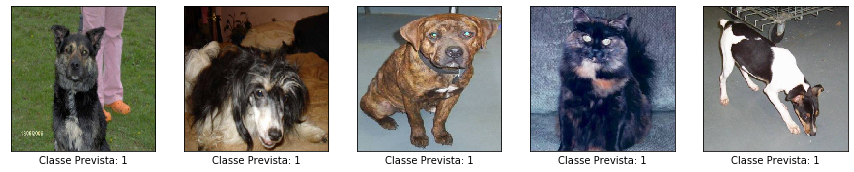

In [155]:
count = 1
plt.figure(figsize=(15,100))
for i, label in enumerate(arr_it_gen[Constantes.IDX_TESTE].labels):
    r = round(ret[i][0])
    if(r != label):
        plt.subplot(1,5,count)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(array_to_img(arr_it_gen[Constantes.IDX_TESTE][i][0][0]))
        plt.xlabel(f"Classe Prevista: {r}")
        count = count + 1
        if(count > 5):
            break;


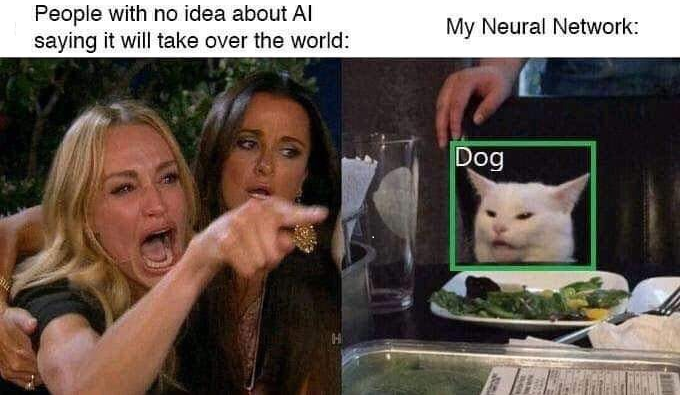

In [89]:
Image(filename='isthisadog.png') 

**[Opcional 3]** Usando a melhor arquitetura, varie os parametros na validação, encontre o melhor resultado e execute o teste.

**\[Opcional 4\]** Use o [tensor board](https://www.tensorflow.org/tensorboard/get_started) para fazer uma análise mais aprofundada do resultado. Apresente os gráficos e uma discussão dos resultados abaixo. O TensorFlow é usado pelo Keras. Você verá que ele cria o modelo de outra forma. Nós usamos a functional API, ela é mais flexivel que a [Sequetial API](http://keras.io/models/sequential/) do keras.

**[Opcional 5]** Faça transfer learning usando a arquitetura VGG (veja instruções abaixo). Pode demorar bastante em uma máquina sem GPU. Usar o [colab](https://colab.research.google.com) pode ser uma boa - coloque o link aqui.

## Transfer Learning 

Como dito em sala, o TransferLearning é uma técnica em que é possível extrair camadas de uma rede neural prétreinada e, com ela, usar em outro dominio. Isso é muito interessante pois, pode-se demorar horas/dias para se treinar uma rede neural e precisa-se de muitas instancias. 

Caso tenhamos uma rede que já foi treinada com milhares/milhões de instancias rotuladas, se deixaramos os pesos "congelados" de algumas camadas, adiantamos o processo de otimização e, assim, conseguimos uma melhor performance. Chollet F. (2017) conseguiu com uma metodologia parecida com essa da prática, um dataset de mesmo tamanho e tranfer learning uma acurácia acima de 90%. Algumas regras importantes também segundo Chollet F., (2017):  

- Em uma CNN, temos geralmente no final camadas FC. Não é recomendável congelar camadas FC, pois, tais camadas não constumam generalizar tanto quanto as camadas Convolucionais;

- Quanto mais próximo nossas instancias são das instancias da rede pretreinada, mais camadas podemos congelar. Por exemplo, a VGG16 treinado com o [ImageNet](http://image-net.org/explore) possui 1000 classes, inclusive, animais. Assim, para nosso problema de classificar cães e gatos, como é proximo desse problema, podemos congelar bastante camadas. Por exemplo, podemos até deixar descongelada apenas a camada de saída. 

O exemplo baixo possui o modelo com a arquitetura VGG16 treinada com o dataset ImageNet e uma função para congelar até uma determinada camada. O parametro `include_top=False` faz com que só usarmos a parte convolucional (sem as FC) desta arquitetura. Temos que criar a parte de FC para ser treinada.

Caso opte por descongelar algumas camadas da VGG16 (e não apenas incrementar) faça da seguinte forma: 

- Mantenha todas as camadas da VGG16 congeladas, adicione as camadas FC (ou CONV) que você deseja e realize o treinamento;
- Descongele as camadas da VGG16 desejadas; 
- Volte a treinar o modelo.

O nome dessa técnica também é chamada de *fine tunning*.

In [86]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))


Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0  

In [35]:
def freeze_first_layers(model,last_freezed_layer_name):
    for layer in model.layers:
        layer.trainable = False
        if layer.name == last_freezed_layer_name:
            break
    return model

def fine_tune_model(conv_base_model):
    last_layer = len(conv_base_model.layers)-1
    
    achatar = layers.Flatten()(conv_base_model.layers[last_layer].output)
    fc = layers.Dense(300,activation="relu",name="Camada2")(achatar)
    saida = layers.Dense(1,activation="sigmoid", name="saida")(fc)
    
    return Model(inputs=conv_base_model.input, outputs=saida)


modelo = fine_tune_model(conv_base)
modelo.summary()

freeze_first_layers(modelo,"block5_pool")
for i,obj in enumerate(modelo.layers):
    print('Nome: ' + obj.name)
    print('Congelado? ' + str(not obj.trainable) + '\n')

In [ ]:
param_default = ParametrosRedeNeural(int_num_epochs=10)
arr_it_gen = get_dataset(param_default,Constantes.ARR_STR_DATA_DIR)

model_VGG16, loss_VGG16, acc_VGG16 = run_model(model=modelo,
                           it_gen_train=arr_it_gen[Constantes.IDX_TREINO],
                           it_gen_validation=arr_it_gen[Constantes.IDX_VALIDACAO],
                           param_training=param_default,
           Image(filename='test.png')                 str_file_to_save="vgg16.h5",
                           int_val_steps=Constantes.QTD_VALIDACAO/param_default.int_batch_size)

Outra utilidade de modelos pretreinados é fazer a extração de atributos, ou seja, representar imagens com uma matriz/vetor de uma camada intermediária de algum modelo pretreinado. Veja um código que extrai os atributos das imagens:

In [36]:
def extract_features(model,layer_name,data_generator,batch_size, sample_size):
    """
    Extrai a saída da camada layer_name para representar as features de
    cada instancia
    
    Adaptado de: https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
    e do livro "Deep Learning with Python" (François Chollet, 2018)
    """
    #obtem o modelo da primeiras camadas do model (até a layer_name)
    output_layer = model.get_layer(layer_name).output 
    model_base = Model(inputs=model.input,
                                     outputs=output_layer)
    #inicializa o vetor de features com a mesma dimensão da ultima camada
    last_layer_shape = output_layer.shape.as_list()
    last_layer_shape[0] = batch_size
    features = np.zeros(last_layer_shape)
    
    #inicializa o vetor de labels com o mesmo tamanho da amostra
    labels = np.zeros(sample_size)
    i = 0
    for inputs_batch, labels in data_generator:
        print(f"Gerando features mini-batch #{i}...")
        #obtem as features
        features_batch = model_base.predict(inputs_batch)
        
        #adiciona as features no batach
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels
        
        i += 1
        print(i)
        #termina assim que atingir o tamanho da amostra
        if (i*batch_size)>=sample_size:
            break
    return labels,features

In [136]:
extract_features(modelo,"block2_conv1",arr_it_gen[Constantes.IDX_TREINO],arr_it_gen[Constantes.IDX_TREINO].batch_size,3)

Gerando features mini-batch #0...
1


(array([0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.], dtype=float32),
 array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           7.68952227e+00, 0.00000000e+00, 1.49109077e+01],
          [0.00000000e+00, 0.00000000e+00, 1.62189376e+00, ...,
           6.05583668e+00, 0.00000000e+00, 9.03883278e-01],
          [0.00000000e+00, 0.00000000e+00, 7.82755435e-01, ...,
           6.98614407e+00, 0.00000000e+00, 2.63850665e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 1.34412932e+00, ...,
           7.57683945e+00, 0.00000000e+00, 2.64507699e+00],
          [0.00000000e+00, 0.00000000e+00, 2.15936232e+00, ...,
           7.99859285e+00, 0.00000000e+00, 4.02119684e+00],
          [0.00000000e+00, 0.00000000e+00, 5.43867493e+00, .

# Bibliografia

- McReynolds, Tom, and David Blythe. **[Advanced graphics programming using OpenGL](https://www.sciencedirect.com/science/article/pii/B9781558606593500147#cesec16). Cap. 14.** Elsevier, 2005.
- Chollet , François. **Deep Learning with Python**. Manning Publications, 2017
- Andrew D.G.. **[Especialização Deep Learning](https://www.coursera.org/specializations/deep-learning), curso Convolutional Neural Networks (semana 1 e 2)**. Coursera. 2019
